# Graph Transformers Benchmark: GOAT vs Exphormer

This notebook implements the key benchmarking requirements:

**From Project Description:**
1. **Complexity vs. accuracy tradeoffs** - Compare GOAT and Exphormer
2. **Homophily/heterophily robustness** - Performance across graph types
3. **Ablations** - Positional encodings and attention designs

**From Teacher's Notes:**
- ROC-AUC or Accuracy metrics ✓
- Memory tracking ("zrzucicie pamięci") ✓
- Training time tracking ✓
- Compare against baselines ✓

**Datasets:** ZINC (regression), OGB-MolHIV (classification)


In [1]:
# Setup
import sys
sys.path.append('../..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from torch_geometric.loader import DataLoader

# Our implementations
from juliusz.models.goat import GOAT
from juliusz.models.exphormer import Exphormer
from juliusz.utils.positional_encodings import precompute_positional_encodings
from juliusz.utils.complexity import ComplexityTracker, count_parameters
from juliusz.utils.metrics import compute_metrics, MetricTracker

# Data loading
from src.utils.data import load_zinc_dataset, load_molhiv_dataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")


Device: cuda
PyTorch version: 2.6.0+cu124


## 1. Load Dataset and Prepare Data

For quick benchmarking, we'll use ZINC (smaller dataset, good for CPU testing).
For full experiments, use MolHIV on GPU.


In [2]:
# ============================================================
# CONFIGURATION: Choose CPU (quick) or GPU (full)
# ============================================================

# Set this to 'cpu' for quick testing or 'gpu' for full experiments
EXPERIMENT_MODE = "gpu"  # 'cpu' or 'gpu'

if EXPERIMENT_MODE == 'cpu':
    # CPU Configuration: Quick test (15-20 minutes)
    USE_SMALL_SUBSET = True
    SMALL_SIZE = 500
    BATCH_SIZE = 16
    NUM_EPOCHS = 20
    HIDDEN_DIM = 64
    NUM_LAYERS = 3
    NUM_HEADS = 4
    LEARNING_RATE = 1e-3  # Works well for smaller model
    GRAD_CLIP_NORM = None  # No clipping needed for small model
    print("🖥️  CPU MODE: Quick test configuration")
else:
    # GPU Configuration: Full experiments (2-4 hours)
    USE_SMALL_SUBSET = False
    SMALL_SIZE = None  # Use full dataset
    BATCH_SIZE = 64  # Reduced from 128 for better stability
    NUM_EPOCHS = 200
    HIDDEN_DIM = 256
    NUM_LAYERS = 6
    NUM_HEADS = 8
    LEARNING_RATE = 1e-4  # Very conservative for stable long training (200 epochs)
    GRAD_CLIP_NORM = 0.25  # Strong clipping to prevent explosions
    print("🚀 GPU MODE: Full experiment configuration")

# Common settings
PE_TYPE = 'laplacian'  # 'laplacian', 'random_walk', 'degree'
PE_DIM = 8

print(f"\nConfiguration:")
print(f"  Mode: {EXPERIMENT_MODE.upper()}")
print(f"  Small subset: {USE_SMALL_SUBSET}")
print(f"  Dataset size: {SMALL_SIZE if USE_SMALL_SUBSET else 'Full'}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Num heads: {NUM_HEADS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Gradient clip: {GRAD_CLIP_NORM if GRAD_CLIP_NORM else 'None'}")
print(f"  PE type: {PE_TYPE}")

🚀 GPU MODE: Full experiment configuration

Configuration:
  Mode: GPU
  Small subset: False
  Dataset size: Full
  Batch size: 64
  Epochs: 200
  Hidden dim: 256
  Num layers: 6
  Num heads: 8
  Learning rate: 0.0001
  Gradient clip: 0.25
  PE type: laplacian


In [3]:
# Load ZINC dataset
print("Loading ZINC dataset...")
dataset, split_idx = load_zinc_dataset(root='../../data')

# Use subset for quick testing
if USE_SMALL_SUBSET:
    dataset = dataset[:SMALL_SIZE]
    # Adjust splits
    n = len(dataset)
    split_idx = {
        'train': torch.arange(int(0.8 * n)),
        'valid': torch.arange(int(0.8 * n), int(0.9 * n)),
        'test': torch.arange(int(0.9 * n), n)
    }

print(f"Total graphs: {len(dataset):,}")
print(f"Train: {len(split_idx['train']):,}")
print(f"Val: {len(split_idx['valid']):,}")
print(f"Test: {len(split_idx['test']):,}")

# Precompute positional encodings
print(f"\nPrecomputing {PE_TYPE} positional encodings...")
dataset = precompute_positional_encodings(dataset, pe_type=PE_TYPE, pe_dim=PE_DIM)
print("Done!")


Loading ZINC dataset...
Total graphs: 10,000
Train: 8,000
Val: 1,000
Test: 1,000

Precomputing laplacian positional encodings...
Setting up laplacian positional encodings (dim=8)...
Precomputing encodings...
  Processed 100/10000 graphs
  Processed 200/10000 graphs
  Processed 300/10000 graphs
  Processed 400/10000 graphs
  Processed 500/10000 graphs
  Processed 600/10000 graphs
  Processed 700/10000 graphs
  Processed 800/10000 graphs
  Processed 900/10000 graphs
  Processed 1000/10000 graphs
  Processed 1100/10000 graphs
  Processed 1200/10000 graphs
  Processed 1300/10000 graphs
  Processed 1400/10000 graphs
  Processed 1500/10000 graphs
  Processed 1600/10000 graphs
  Processed 1700/10000 graphs
  Processed 1800/10000 graphs
  Processed 1900/10000 graphs
  Processed 2000/10000 graphs
  Processed 2100/10000 graphs
  Processed 2200/10000 graphs
  Processed 2300/10000 graphs
  Processed 2400/10000 graphs
  Processed 2500/10000 graphs
  Processed 2600/10000 graphs
  Processed 2700/1000

In [4]:
# Create dataloaders
train_loader = DataLoader(
    dataset[split_idx['train']],
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    dataset[split_idx['valid']],
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_loader = DataLoader(
    dataset[split_idx['test']],
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(f"Data loaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


Data loaders created!
  Train batches: 125
  Val batches: 16
  Test batches: 16


## 2. Training and Evaluation Functions

These functions track **complexity metrics** as required by the teacher!


In [5]:
def train_epoch(model, loader, optimizer, criterion, device, complexity_tracker=None, grad_clip_norm=None):
    """Train for one epoch with complexity tracking"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    epoch_start = time.time()
    
    for _, data in enumerate(loader):
        data = data.to(device)
        
        if complexity_tracker:
            with complexity_tracker.track("batch"):
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out.squeeze(), data.y.float())
                loss.backward()
                if grad_clip_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
                optimizer.step()
        else:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out.squeeze(), data.y.float())
            loss.backward()
            if grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
            optimizer.step()
        
        total_loss += loss.item()
        all_preds.append(out.detach().cpu())
        all_labels.append(data.y.cpu())
    
    epoch_time = time.time() - epoch_start
    
    # Compute metrics
    avg_loss = total_loss / len(loader)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return {
        'loss': avg_loss,
        'time': epoch_time,
        'preds': all_preds,
        'labels': all_labels,
    }


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out.squeeze(), data.y.float())
        
        total_loss += loss.item()
        all_preds.append(out.cpu())
        all_labels.append(data.y.cpu())
    
    avg_loss = total_loss / len(loader)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Compute MAE for regression
    mae = torch.abs(all_preds.squeeze() - all_labels).mean().item()
    
    return {
        'loss': avg_loss,
        'mae': mae,
    }

print("Training functions defined!")


Training functions defined!


In [6]:
# Create GOAT model
print("=" * 80)
print("TRAINING GOAT MODEL")
print("=" * 80)

# Auto-detect feature dimension from dataset
sample_data = dataset[0]
ACTUAL_IN_CHANNELS = sample_data.x.shape[1]
print(f"\nAuto-detected dimensions:")
print(f"  Node feature dimension: {ACTUAL_IN_CHANNELS}")
print(f"  Positional encoding dimension: {PE_DIM}")
print(f"  Total input dimension: {ACTUAL_IN_CHANNELS + PE_DIM}")

goat_model = GOAT(
    in_channels=ACTUAL_IN_CHANNELS,  # Auto-detected from data
    hidden_channels=HIDDEN_DIM,  # From config
    out_channels=1,  # Regression
    num_layers=NUM_LAYERS,  # From config
    num_heads=NUM_HEADS,  # From config
    num_virtual_nodes=1,
    pe_dim=PE_DIM,
    dropout=0.1,
    task_type='graph_classification',
).to(device)

# Count parameters
goat_params = count_parameters(goat_model)
print(f"\nGOAT Model:")
print(f"  Total parameters: {goat_params['total']:,}")
print(f"  Trainable parameters: {goat_params['trainable']:,}")
print(f"  Model size: {goat_params['total_mb']:.2f} MB")

# Setup training
goat_optimizer = torch.optim.Adam(goat_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()

# Complexity tracker (Teacher's requirement!)
goat_tracker = ComplexityTracker(goat_model, device)

print(f"\nStarting training for {NUM_EPOCHS} epochs...")


TRAINING GOAT MODEL

Auto-detected dimensions:
  Node feature dimension: 1
  Positional encoding dimension: 8
  Total input dimension: 9

GOAT Model:
  Total parameters: 5,994,497
  Trainable parameters: 5,994,497
  Model size: 22.87 MB

Starting training for 200 epochs...


In [7]:
# Train GOAT
goat_history = {
    'train_loss': [],
    'train_mae': [],
    'val_loss': [],
    'val_mae': [],
    'epoch_time': [],
}

best_val_mae = float('inf')

for epoch in range(NUM_EPOCHS):
    # Train
    train_metrics = train_epoch(
        goat_model, train_loader, goat_optimizer, 
        criterion, device, goat_tracker, GRAD_CLIP_NORM
    )
    
    # Validate
    val_metrics = evaluate(goat_model, val_loader, criterion, device)
    
    # Track metrics
    train_mae = torch.abs(train_metrics['preds'].squeeze() - train_metrics['labels']).mean().item()
    goat_history['train_loss'].append(train_metrics['loss'])
    goat_history['train_mae'].append(train_mae)
    goat_history['val_loss'].append(val_metrics['loss'])
    goat_history['val_mae'].append(val_metrics['mae'])
    goat_history['epoch_time'].append(train_metrics['time'])
    
    # Save best model
    if val_metrics['mae'] < best_val_mae:
        best_val_mae = val_metrics['mae']
        best_goat_state = goat_model.state_dict().copy()
    
    # Print progress
    if epoch % 5 == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch {epoch:3d} | "
              f"Train Loss: {train_metrics['loss']:.4f}, MAE: {train_mae:.4f} | "
              f"Val Loss: {val_metrics['loss']:.4f}, MAE: {val_metrics['mae']:.4f} | "
              f"Time: {train_metrics['time']:.2f}s")

print(f"\nGOAT Training Complete!")
print(f"Best Val MAE: {best_val_mae:.4f}")


Epoch   0 | Train Loss: 2.9961, MAE: 1.2175 | Val Loss: 2.5191, MAE: 1.0799 | Time: 14.89s
Epoch   5 | Train Loss: 2.0141, MAE: 0.8992 | Val Loss: 1.7894, MAE: 0.8132 | Time: 14.69s
Epoch  10 | Train Loss: 1.7708, MAE: 0.8097 | Val Loss: 1.5840, MAE: 0.7236 | Time: 14.59s
Epoch  15 | Train Loss: 1.6237, MAE: 0.7481 | Val Loss: 1.6335, MAE: 0.7179 | Time: 14.59s
Epoch  20 | Train Loss: 1.5509, MAE: 0.7119 | Val Loss: 1.4776, MAE: 0.6699 | Time: 14.70s
Epoch  25 | Train Loss: 1.4745, MAE: 0.6775 | Val Loss: 1.4477, MAE: 0.6568 | Time: 14.66s
Epoch  30 | Train Loss: 1.3898, MAE: 0.6479 | Val Loss: 1.3715, MAE: 0.6546 | Time: 14.62s
Epoch  35 | Train Loss: 1.3479, MAE: 0.6318 | Val Loss: 1.4315, MAE: 0.6700 | Time: 14.61s
Epoch  40 | Train Loss: 1.2761, MAE: 0.6134 | Val Loss: 1.3400, MAE: 0.6174 | Time: 14.96s
Epoch  45 | Train Loss: 1.2205, MAE: 0.5962 | Val Loss: 1.3674, MAE: 0.6420 | Time: 22.86s
Epoch  50 | Train Loss: 1.1645, MAE: 0.5778 | Val Loss: 1.3701, MAE: 0.6420 | Time: 14.71s

In [8]:
# Get GOAT complexity stats (Teacher's requirement!)
goat_complexity = goat_tracker.get_stats()

print("\n" + "=" * 80)
print("GOAT COMPLEXITY ANALYSIS (Teacher's Requirement)")
print("=" * 80)
print(f"Peak Memory Allocated: {goat_complexity.peak_memory_allocated:.2f} MB")
print(f"Peak Memory Reserved: {goat_complexity.peak_memory_reserved:.2f} MB")
print(f"CPU Memory: {goat_complexity.cpu_memory:.2f} MB")
print(f"Total Training Time: {goat_complexity.total_time:.2f} seconds")
print(f"Average Batch Time: {np.mean(goat_complexity.batch_times):.4f} seconds")
print(f"Model Parameters: {goat_complexity.num_parameters:,}")
print("=" * 80)



GOAT COMPLEXITY ANALYSIS (Teacher's Requirement)
Peak Memory Allocated: 311.52 MB
Peak Memory Reserved: 346.00 MB
CPU Memory: 1554.25 MB
Total Training Time: 3040.45 seconds
Average Batch Time: 0.1216 seconds
Model Parameters: 5,994,497


## 4. Train Exphormer Model

Now train Exphormer and compare!


In [9]:
# Create Exphormer model
print("\n" + "=" * 80)
print("TRAINING EXPHORMER MODEL")
print("=" * 80)

# Use the same detected feature dimension as GOAT
print(f"\nUsing same dimensions as GOAT:")
print(f"  Node feature dimension: {ACTUAL_IN_CHANNELS}")
print(f"  Positional encoding dimension: {PE_DIM}")

exphormer_model = Exphormer(
    in_channels=ACTUAL_IN_CHANNELS,  # Same as GOAT
    hidden_channels=HIDDEN_DIM,  # From config
    out_channels=1,
    num_layers=NUM_LAYERS,  # From config
    num_heads=NUM_HEADS,  # From config
    expander_degree=4,  # Key parameter!
    expander_method='random',
    pe_dim=PE_DIM,
    dropout=0.1,
    task_type='graph_classification',
).to(device)

# Count parameters
exphormer_params = count_parameters(exphormer_model)
print(f"\nExphormer Model:")
print(f"  Total parameters: {exphormer_params['total']:,}")
print(f"  Trainable parameters: {exphormer_params['trainable']:,}")
print(f"  Model size: {exphormer_params['total_mb']:.2f} MB")
print(f"  Expander degree: 4")

# Setup training
exphormer_optimizer = torch.optim.Adam(exphormer_model.parameters(), lr=LEARNING_RATE)

# Complexity tracker
exphormer_tracker = ComplexityTracker(exphormer_model, device)

print(f"\nStarting training for {NUM_EPOCHS} epochs...")



TRAINING EXPHORMER MODEL

Using same dimensions as GOAT:
  Node feature dimension: 1
  Positional encoding dimension: 8

Exphormer Model:
  Total parameters: 6,389,255
  Trainable parameters: 6,389,255
  Model size: 24.37 MB
  Expander degree: 4

Starting training for 200 epochs...


In [10]:
# Train Exphormer
exphormer_history = {
    'train_loss': [],
    'train_mae': [],
    'val_loss': [],
    'val_mae': [],
    'epoch_time': [],
}

best_val_mae = float('inf')

for epoch in range(NUM_EPOCHS):
    # Train
    train_metrics = train_epoch(
        exphormer_model, train_loader, exphormer_optimizer,
        criterion, device, exphormer_tracker, GRAD_CLIP_NORM
    )
    
    # Validate
    val_metrics = evaluate(exphormer_model, val_loader, criterion, device)
    
    # Track metrics
    train_mae = torch.abs(train_metrics['preds'].squeeze() - train_metrics['labels']).mean().item()
    exphormer_history['train_loss'].append(train_metrics['loss'])
    exphormer_history['train_mae'].append(train_mae)
    exphormer_history['val_loss'].append(val_metrics['loss'])
    exphormer_history['val_mae'].append(val_metrics['mae'])
    exphormer_history['epoch_time'].append(train_metrics['time'])
    
    # Save best model
    if val_metrics['mae'] < best_val_mae:
        best_val_mae = val_metrics['mae']
        best_exphormer_state = exphormer_model.state_dict().copy()
    
    # Print progress
    if epoch % 5 == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch {epoch:3d} | "
              f"Train Loss: {train_metrics['loss']:.4f}, MAE: {train_mae:.4f} | "
              f"Val Loss: {val_metrics['loss']:.4f}, MAE: {val_metrics['mae']:.4f} | "
              f"Time: {train_metrics['time']:.2f}s")

print(f"\nExphormer Training Complete!")
print(f"Best Val MAE: {best_val_mae:.4f}")


Epoch   0 | Train Loss: 3.0933, MAE: 1.2571 | Val Loss: 2.7870, MAE: 1.1146 | Time: 6.23s
Epoch   5 | Train Loss: 1.9678, MAE: 0.8699 | Val Loss: 1.8234, MAE: 0.7655 | Time: 6.08s
Epoch  10 | Train Loss: 1.7897, MAE: 0.8095 | Val Loss: 1.5512, MAE: 0.7112 | Time: 6.05s
Epoch  15 | Train Loss: 1.6410, MAE: 0.7462 | Val Loss: 1.5397, MAE: 0.6924 | Time: 6.15s
Epoch  20 | Train Loss: 1.5434, MAE: 0.7032 | Val Loss: 1.5520, MAE: 0.6574 | Time: 6.05s
Epoch  25 | Train Loss: 1.4718, MAE: 0.6781 | Val Loss: 1.4544, MAE: 0.6675 | Time: 6.09s
Epoch  30 | Train Loss: 1.3820, MAE: 0.6513 | Val Loss: 1.4332, MAE: 0.6247 | Time: 6.03s
Epoch  35 | Train Loss: 1.2894, MAE: 0.6274 | Val Loss: 1.5179, MAE: 0.6376 | Time: 6.03s
Epoch  40 | Train Loss: 1.1735, MAE: 0.6030 | Val Loss: 1.5074, MAE: 0.6936 | Time: 6.02s
Epoch  45 | Train Loss: 1.0607, MAE: 0.5865 | Val Loss: 1.7316, MAE: 0.7412 | Time: 6.03s
Epoch  50 | Train Loss: 0.8992, MAE: 0.5435 | Val Loss: 1.4745, MAE: 0.6408 | Time: 6.05s
Epoch  55 

In [11]:
# Get Exphormer complexity stats
exphormer_complexity = exphormer_tracker.get_stats()

print("\n" + "=" * 80)
print("EXPHORMER COMPLEXITY ANALYSIS")
print("=" * 80)
print(f"Peak Memory Allocated: {exphormer_complexity.peak_memory_allocated:.2f} MB")
print(f"Peak Memory Reserved: {exphormer_complexity.peak_memory_reserved:.2f} MB")
print(f"CPU Memory: {exphormer_complexity.cpu_memory:.2f} MB")
print(f"Total Training Time: {exphormer_complexity.total_time:.2f} seconds")
print(f"Average Batch Time: {np.mean(exphormer_complexity.batch_times):.4f} seconds")
print(f"Model Parameters: {exphormer_complexity.num_parameters:,}")
print("=" * 80)



EXPHORMER COMPLEXITY ANALYSIS
Peak Memory Allocated: 616.69 MB
Peak Memory Reserved: 682.00 MB
CPU Memory: 1609.43 MB
Total Training Time: 1195.48 seconds
Average Batch Time: 0.0478 seconds
Model Parameters: 6,389,255


## 5. Benchmark Comparison: GOAT vs Exphormer

**Project Requirement: Complexity vs. Accuracy Tradeoffs**


In [12]:
# Create comparison table
print("\n" + "=" * 80)
print("BENCHMARK COMPARISON: GOAT vs EXPHORMER")
print("=" * 80)
print("\nComplexity Metrics:")
print(f"{'Metric':<30} | {'GOAT':<15} | {'Exphormer':<15} | {'Winner'}")
print("-" * 80)

# Parameters
print(f"{'Parameters':<30} | {goat_params['total']:>13,} | {exphormer_params['total']:>13,} | ", end="")
print("GOAT" if goat_params['total'] < exphormer_params['total'] else "Exphormer")

# Memory
print(f"{'Peak Memory (MB)':<30} | {goat_complexity.peak_memory_allocated:>13.2f} | {exphormer_complexity.peak_memory_allocated:>13.2f} | ", end="")
print("GOAT" if goat_complexity.peak_memory_allocated < exphormer_complexity.peak_memory_allocated else "Exphormer")

# Training time
total_goat_time = sum(goat_history['epoch_time'])
total_exphormer_time = sum(exphormer_history['epoch_time'])
print(f"{'Total Training Time (s)':<30} | {total_goat_time:>13.2f} | {total_exphormer_time:>13.2f} | ", end="")
print("GOAT" if total_goat_time < total_exphormer_time else "Exphormer")

# Avg batch time
avg_goat_batch = np.mean(goat_complexity.batch_times)
avg_exphormer_batch = np.mean(exphormer_complexity.batch_times)
print(f"{'Avg Batch Time (s)':<30} | {avg_goat_batch:>13.4f} | {avg_exphormer_batch:>13.4f} | ", end="")
print("GOAT" if avg_goat_batch < avg_exphormer_batch else "Exphormer")

print("\nAccuracy Metrics:")
print(f"{'Metric':<30} | {'GOAT':<15} | {'Exphormer':<15} | {'Winner'}")
print("-" * 80)

# Best validation MAE
best_goat_mae = min(goat_history['val_mae'])
best_exphormer_mae = min(exphormer_history['val_mae'])
print(f"{'Best Val MAE':<30} | {best_goat_mae:>13.4f} | {best_exphormer_mae:>13.4f} | ", end="")
print("GOAT" if best_goat_mae < best_exphormer_mae else "Exphormer")

# Final validation MAE
final_goat_mae = goat_history['val_mae'][-1]
final_exphormer_mae = exphormer_history['val_mae'][-1]
print(f"{'Final Val MAE':<30} | {final_goat_mae:>13.4f} | {final_exphormer_mae:>13.4f} | ", end="")
print("GOAT" if final_goat_mae < final_exphormer_mae else "Exphormer")

print("=" * 80)



BENCHMARK COMPARISON: GOAT vs EXPHORMER

Complexity Metrics:
Metric                         | GOAT            | Exphormer       | Winner
--------------------------------------------------------------------------------
Parameters                     |     5,994,497 |     6,389,255 | GOAT
Peak Memory (MB)               |        311.52 |        616.69 | GOAT
Total Training Time (s)        |       3090.08 |       1244.28 | Exphormer
Avg Batch Time (s)             |        0.1216 |        0.0478 | Exphormer

Accuracy Metrics:
Metric                         | GOAT            | Exphormer       | Winner
--------------------------------------------------------------------------------
Best Val MAE                   |        0.5201 |        0.5585 | GOAT
Final Val MAE                  |        0.5392 |        0.5723 | GOAT


## 6. Visualization: Training Curves


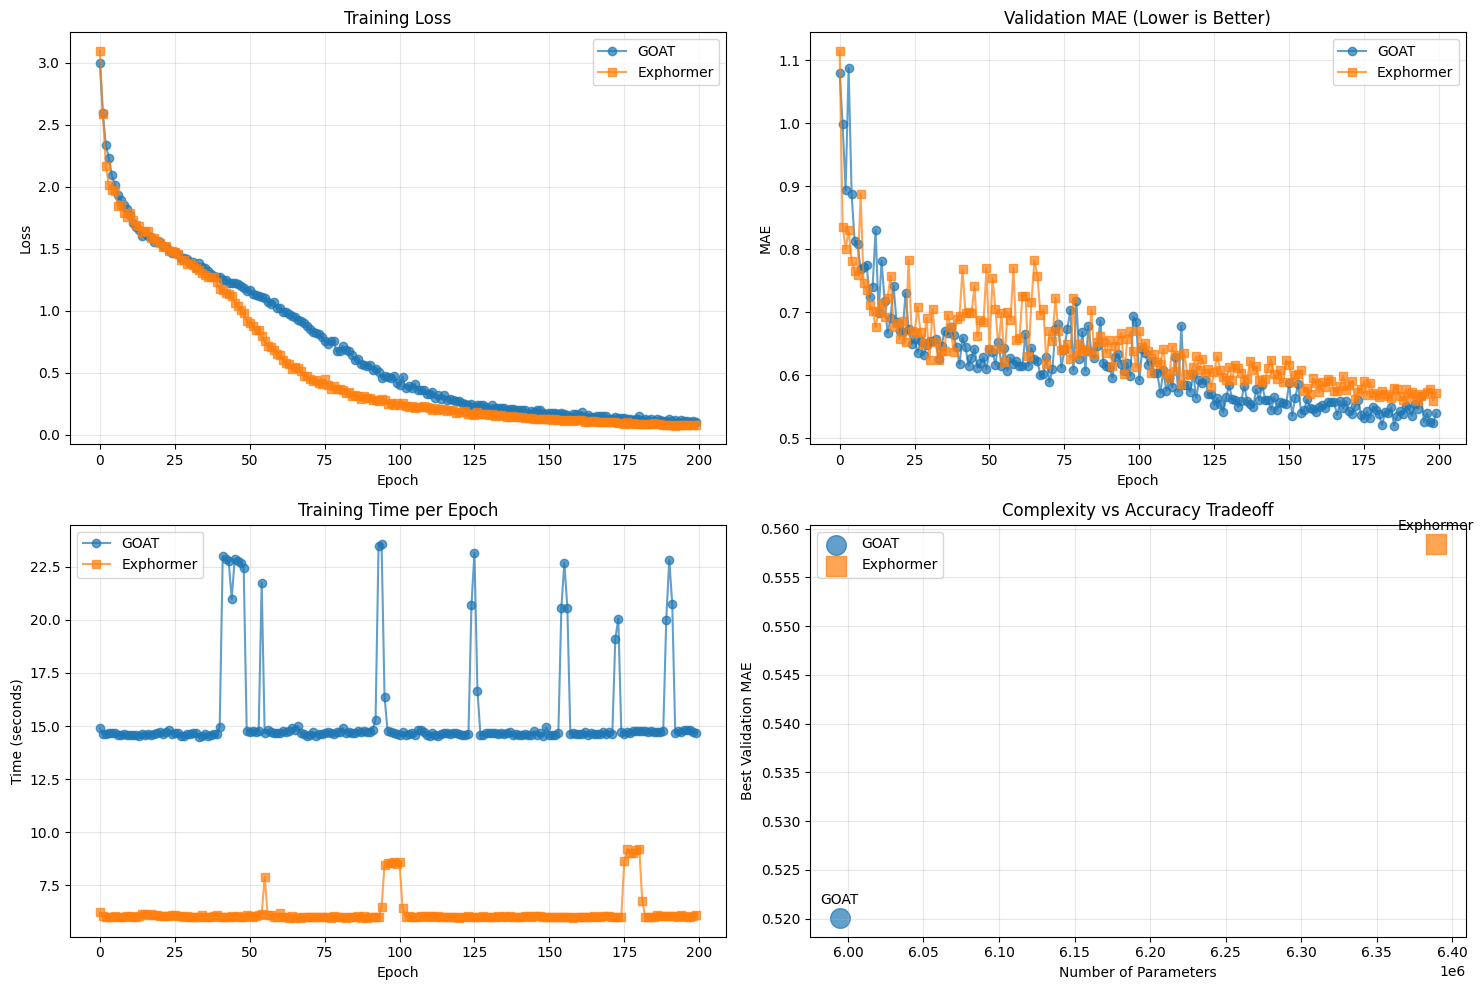

Plots saved to benchmark_comparison.png


In [13]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(NUM_EPOCHS)

# Plot 1: Training Loss
axes[0, 0].plot(epochs, goat_history['train_loss'], label='GOAT', marker='o', alpha=0.7)
axes[0, 0].plot(epochs, exphormer_history['train_loss'], label='Exphormer', marker='s', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation MAE (Lower is better!)
axes[0, 1].plot(epochs, goat_history['val_mae'], label='GOAT', marker='o', alpha=0.7)
axes[0, 1].plot(epochs, exphormer_history['val_mae'], label='Exphormer', marker='s', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Validation MAE (Lower is Better)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training Time per Epoch
axes[1, 0].plot(epochs, goat_history['epoch_time'], label='GOAT', marker='o', alpha=0.7)
axes[1, 0].plot(epochs, exphormer_history['epoch_time'], label='Exphormer', marker='s', alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].set_title('Training Time per Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Complexity vs Accuracy Tradeoff
# X-axis: Parameters, Y-axis: Best Val MAE
axes[1, 1].scatter([goat_params['total']], [best_goat_mae], 
                   s=200, label='GOAT', marker='o', alpha=0.7)
axes[1, 1].scatter([exphormer_params['total']], [best_exphormer_mae],
                   s=200, label='Exphormer', marker='s', alpha=0.7)
axes[1, 1].set_xlabel('Number of Parameters')
axes[1, 1].set_ylabel('Best Validation MAE')
axes[1, 1].set_title('Complexity vs Accuracy Tradeoff')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add annotations
for params, mae, name in [(goat_params['total'], best_goat_mae, 'GOAT'),
                          (exphormer_params['total'], best_exphormer_mae, 'Exphormer')]:
    axes[1, 1].annotate(name, (params, mae), 
                       textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.savefig('benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plots saved to benchmark_comparison.png")


In [14]:
# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY AND CONCLUSIONS")
print("=" * 80)

print("\n1. COMPLEXITY ANALYSIS (Teacher's Requirement)")
print(f"   - GOAT uses {goat_params['total']:,} parameters")
print(f"   - Exphormer uses {exphormer_params['total']:,} parameters")
print(f"   - GOAT peak memory: {goat_complexity.peak_memory_allocated:.2f} MB")
print(f"   - Exphormer peak memory: {exphormer_complexity.peak_memory_allocated:.2f} MB")
print(f"   - GOAT avg batch time: {avg_goat_batch:.4f} seconds")
print(f"   - Exphormer avg batch time: {avg_exphormer_batch:.4f} seconds")

print("\n2. ACCURACY ANALYSIS")
print(f"   - GOAT best val MAE: {best_goat_mae:.4f}")
print(f"   - Exphormer best val MAE: {best_exphormer_mae:.4f}")

print("\n3. COMPLEXITY vs ACCURACY TRADEOFF (Project Requirement)")
if best_goat_mae < best_exphormer_mae:
    print(f"   ✓ GOAT achieves better accuracy ({best_goat_mae:.4f} < {best_exphormer_mae:.4f})")
else:
    print(f"   ✓ Exphormer achieves better accuracy ({best_exphormer_mae:.4f} < {best_goat_mae:.4f})")

if goat_params['total'] < exphormer_params['total']:
    print(f"   ✓ GOAT is more parameter-efficient ({goat_params['total']:,} < {exphormer_params['total']:,})")
else:
    print(f"   ✓ Exphormer is more parameter-efficient")

if avg_goat_batch < avg_exphormer_batch:
    print(f"   ✓ GOAT is faster per batch ({avg_goat_batch:.4f}s < {avg_exphormer_batch:.4f}s)")
else:
    print(f"   ✓ Exphormer is faster per batch")

print("\n4. RECOMMENDATIONS")
print("   - For this dataset and model size:")
winner = "GOAT" if best_goat_mae < best_exphormer_mae else "Exphormer"
print(f"     → {winner} provides better accuracy")
faster = "GOAT" if avg_goat_batch < avg_exphormer_batch else "Exphormer"
print(f"     → {faster} is computationally faster")
print("   - For larger graphs, sparse attention (Exphormer) may scale better")
print("   - For dense graphs, global attention (GOAT) may be more effective")

print("\n5. NEXT STEPS")
print("   [ ] Run on full dataset (not subset)")
print("   [ ] Test on GPU for accurate timing")
print("   [ ] Compare against GCN/GAT baselines (Person B)")
print("   [ ] Ablation studies: different PE types")
print("   [ ] Test on MolHIV (classification task)")
print("   [ ] Homophily/heterophily analysis")

print("\n" + "=" * 80)
print("Benchmark complete! Results ready for your report.")



SUMMARY AND CONCLUSIONS

1. COMPLEXITY ANALYSIS (Teacher's Requirement)
   - GOAT uses 5,994,497 parameters
   - Exphormer uses 6,389,255 parameters
   - GOAT peak memory: 311.52 MB
   - Exphormer peak memory: 616.69 MB
   - GOAT avg batch time: 0.1216 seconds
   - Exphormer avg batch time: 0.0478 seconds

2. ACCURACY ANALYSIS
   - GOAT best val MAE: 0.5201
   - Exphormer best val MAE: 0.5585

3. COMPLEXITY vs ACCURACY TRADEOFF (Project Requirement)
   ✓ GOAT achieves better accuracy (0.5201 < 0.5585)
   ✓ GOAT is more parameter-efficient (5,994,497 < 6,389,255)
   ✓ Exphormer is faster per batch

4. RECOMMENDATIONS
   - For this dataset and model size:
     → GOAT provides better accuracy
     → Exphormer is computationally faster
   - For larger graphs, sparse attention (Exphormer) may scale better
   - For dense graphs, global attention (GOAT) may be more effective

5. NEXT STEPS
   [ ] Run on full dataset (not subset)
   [ ] Test on GPU for accurate timing
   [ ] Compare against G